### Import



In [ ]:
import os
import random
import numpy as np
import collections
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import GroupKFold
from PIL import Image
import re
from torchvision import transforms, models
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Difine Seed

In [ ]:
# Set a fixed seed value for reproducibility
seed = 42

# Set the seed for Python's built-in random module
random.seed(seed)

# Set the seed for NumPy
np.random.seed(seed)

# Set the seed for PyTorch
torch.manual_seed(seed)

# Ensure that the seed is set for CUDA as well if using GPU
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if using multi-GPU

# Additional configuration for determinism
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Data Utils

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]

        image = Image.open(file_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Function to extract patient ID from filenames (for k-fold cross validation)
def extract_patient_id(filename):
    match = re.match(r'([\w\s]+-\d+of\d+)', filename)
    if match:
        return match.group(1)
    else:
        raise ValueError(f"Filename {filename} does not match the expected pattern.")

# Function to load data and split into file paths, labels, and patient IDs
def load_data(root_dir, classes):
    file_paths = []
    labels = []
    patient_ids = []

    for class_index, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        for filename in os.listdir(class_dir):
            file_path = os.path.join(class_dir, filename)
            file_paths.append(file_path)
            labels.append(class_index)
            patient_ids.append(extract_patient_id(filename))

    return file_paths, labels, patient_ids

# Define transform
transform = transforms.Compose([
    transforms.Resize((240, 240)),
    transforms.ToTensor(),
])

In [ ]:
# Define root directory and classes
root_dir = "/content/drive/MyDrive/projects/SecondTry/JPG_480/train"
test_root_dir = "/content/drive/MyDrive/projects/SecondTry/JPG_480/test"
test_root_dir_2 = "/content/drive/MyDrive/projects/SecondTry/JPG_480/val"
classes = ['Good', 'Bad', 'Null']

# Load file paths, labels, and patient IDs
file_paths, labels, patient_ids = load_data(root_dir, classes)
test_file_paths, test_labels, test_patient_ids = load_data(test_root_dir, classes)
test_file_paths_2, test_labels_2, test_patient_ids_2 = load_data(test_root_dir_2, classes)

In [ ]:
# Create a test dataset
test_dataset = CustomDataset(test_file_paths, test_labels, transform=transform)
test_dataset_2 = CustomDataset(test_file_paths_2, test_labels_2, transform=transform)

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader_2 = DataLoader(test_dataset_2, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### K-Fold

In [ ]:
# Initialize GroupKFold
num_folds = 5
gkf = GroupKFold(n_splits=num_folds)

### Model

In [ ]:
class ModifiedResNet34(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.6):
        super(ModifiedResNet34, self).__init__()
        self.resnet = models.resnet34(pretrained=True)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(num_features, num_classes)
        )

    def forward(self, x):
        return self.resnet(x)

### Hyperparameter

In [ ]:
fold_results = []  # To store the last validation accuracy of each fold
best_model_per_fold = None  # To store the best model based on the last validation accuracy
best_fold_acc = 0.0  # Track the highest validation accuracy among the last epochs of all folds

num_epochs = 15

# Total number of unique patients across the dataset
total_unique_patients = len(set(patient_ids))

# Define the number of classes
num_classes = len(classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Train Utils

In [ ]:
# Function to train the model for a single epoch
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

# Function to validate the model
def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = correct.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc


### Training

In [ ]:
for fold, (train_idx, val_idx) in enumerate(gkf.split(file_paths, labels, groups=patient_ids)):
    print(f'Fold {fold+1}/{num_folds}')

    # Get patient IDs for training and validation sets
    train_patient_ids = [patient_ids[i] for i in train_idx]
    val_patient_ids = [patient_ids[i] for i in val_idx]

    # Check for overlap between training and validation patient IDs
    overlap = set(train_patient_ids) & set(val_patient_ids)
    if overlap:
        print(f"Overlap detected in fold {fold+1}! Overlapping patient IDs: {overlap}")
    else:
        print(f"No overlap between training and validation patient sets in fold {fold+1}.")

    # Calculate the percentage of unique patients in the validation set
    unique_val_patients = len(set(val_patient_ids))
    val_percentage = (unique_val_patients / total_unique_patients) * 100
    print(f'Percentage of patients in validation set for fold {fold+1}: {val_percentage:.2f}%')

    # Create training and validation datasets for this fold
    train_dataset = CustomDataset([file_paths[i] for i in train_idx], [labels[i] for i in train_idx], transform=transform)
    val_dataset = CustomDataset([file_paths[i] for i in val_idx], [labels[i] for i in val_idx], transform=transform)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

    # Initialize the model for this fold (reinitialize weights)
    model = ModifiedResNet34(num_classes=num_classes, dropout_prob=0.5)
    model = model.to(device)

    # Define optimizer and loss function
    optimizer = optim.SGD(model.parameters(), lr=0.000714, momentum=0.9)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        # Train and validate for one epoch
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Save the last validation accuracy of the current fold
    fold_results.append(val_acc.item())

    print(f'Last Validation Accuracy for Fold {fold+1}: {val_acc:.4f}')

    # Track the best model and accuracy among the last validation accuracies
    if val_acc > best_fold_acc:
        best_fold_acc = val_acc
        best_model_per_fold = copy.deepcopy(model.state_dict())  # Store the best model weights

# Calculate the average accuracy across all folds
average_acc = sum(fold_results) / len(fold_results)
print(f'Average Accuracy across all folds: {average_acc:.4f}')

# Print the best validation accuracy among the last validation accuracies
print(f'Best Validation Accuracy among all folds: {best_fold_acc:.4f}')

# Load the best model weights from the fold with the highest last validation accuracy
model.load_state_dict(best_model_per_fold)

Fold 1/5
No overlap between training and validation patient sets in fold 1.
Percentage of patients in validation set for fold 1: 20.25%


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can als

Epoch 1/15
Train Loss: 1.1852, Train Acc: 0.3857
Val Loss: 1.2343, Val Acc: 0.2573
Epoch 2/15
Train Loss: 0.9869, Train Acc: 0.5114
Val Loss: 1.1250, Val Acc: 0.4108
Epoch 3/15
Train Loss: 0.8697, Train Acc: 0.5988
Val Loss: 0.8825, Val Acc: 0.6680
Epoch 4/15
Train Loss: 0.7963, Train Acc: 0.6611
Val Loss: 0.8261, Val Acc: 0.6722
Epoch 5/15
Train Loss: 0.6717, Train Acc: 0.7391
Val Loss: 0.8182, Val Acc: 0.7095
Epoch 6/15
Train Loss: 0.6032, Train Acc: 0.7661
Val Loss: 0.7206, Val Acc: 0.7510
Epoch 7/15
Train Loss: 0.5172, Train Acc: 0.8430
Val Loss: 0.6927, Val Acc: 0.7386
Epoch 8/15
Train Loss: 0.4838, Train Acc: 0.8368
Val Loss: 0.6775, Val Acc: 0.7593
Epoch 9/15
Train Loss: 0.4337, Train Acc: 0.8565
Val Loss: 0.6297, Val Acc: 0.7801
Epoch 10/15
Train Loss: 0.3951, Train Acc: 0.8909
Val Loss: 0.6430, Val Acc: 0.7510
Epoch 11/15
Train Loss: 0.3606, Train Acc: 0.8950
Val Loss: 0.6021, Val Acc: 0.7718
Epoch 12/15
Train Loss: 0.3093, Train Acc: 0.9304
Val Loss: 0.5679, Val Acc: 0.7635
E

<All keys matched successfully>

### Evaluation

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Accuracy : 0.6684


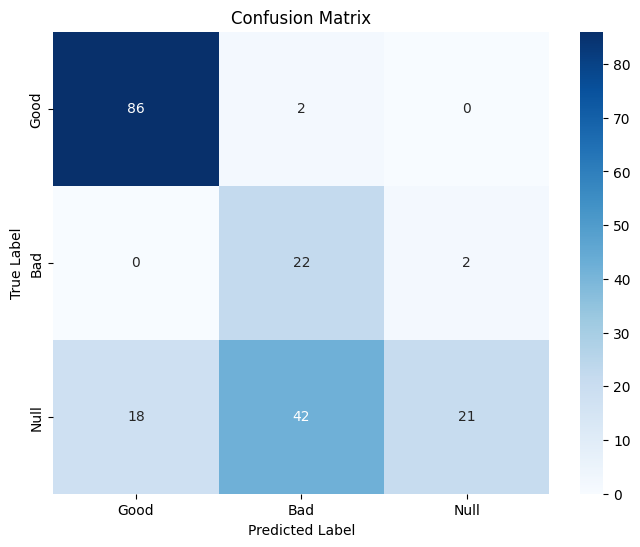

In [ ]:
# Evaluate the model on the new test patient dataset
model.eval()
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())


# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

accuracy_merged = np.trace(conf_matrix) / np.sum(conf_matrix)
# Print accuracy for merged classes
print(f"Accuracy : {accuracy_merged:.4f}")

# Display the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Good', 'Bad', 'Null'],
            yticklabels=['Good', 'Bad', 'Null'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Compute precision, recall, and F1-score
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

cls_report = classification_report(true_labels, predicted_labels, target_names=['Good', 'Bad', 'Null'])

print("Classification Report:")
print(cls_report)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Classification Report:
              precision    recall  f1-score   support

        Good       0.83      0.98      0.90        88
         Bad       0.33      0.92      0.49        24
        Null       0.91      0.26      0.40        81

    accuracy                           0.67       193
   macro avg       0.69      0.72      0.60       193
weighted avg       0.80      0.67      0.64       193

Precision: 0.8017
Recall: 0.6684
F1-Score: 0.6387


In [ ]:
#file path for saving the trained model
model_path = '/content/drive/MyDrive/projects/SecondTry/Saved_models/ResNet34_checkpoint_15Epoch_without_momentum.pth'

# Save the model's state dictionary to the file path
torch.save(model.state_dict(), model_path)